<h2>Define Learning Rate Policy</h2>

Learning rate is one of the most important hyperparameter to train for you neural network in order to achieve good performance. In the tutorial, you will learn how to specify predefined learning rate policy and customize your own learning rate with FCMP function.

In [1]:
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
import swat
import sys
import dlpy
from dlpy.layers import *
from dlpy.model import *
from dlpy.images import ImageTable
from dlpy.sequential import Sequential
from dlpy.lr_scheduler import *

In [2]:
host_name='your_host_name'
port_number='your_port_number'
sess = swat.CAS(host_name, port_number)

## Build network
First, Let's build a simple ResNet like model.

In [3]:
def conv_block(x, filters, size, stride=1, mode='same', act=True):
    x = Conv2d(filters, size, size, act='identity', include_bias=False, stride=stride)(x)
    x = BN(act='relu' if act else 'identity')(x)
    return x

In [4]:
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, 2)
    x = conv_block(x, nf, 3, 1, act=False)
    return Res()([x, ip])

In [5]:
inp_resnet= Input(3, 112, 112, scale = 1.0 / 255, name='InputLayer_1')
x=conv_block(inp_resnet, 64, 9, 1)
for i in range(4): x=res_block(x)
x=Conv2d(20, 9, 9, act='tanh')(x)
x=Pooling(7, 7)(x)
output = OutputLayer(n=2)(x)
resnet_like_model = Model(sess, inputs = inp_resnet, outputs = output)
resnet_like_model.compile()

NOTE: Model compiled successfully.


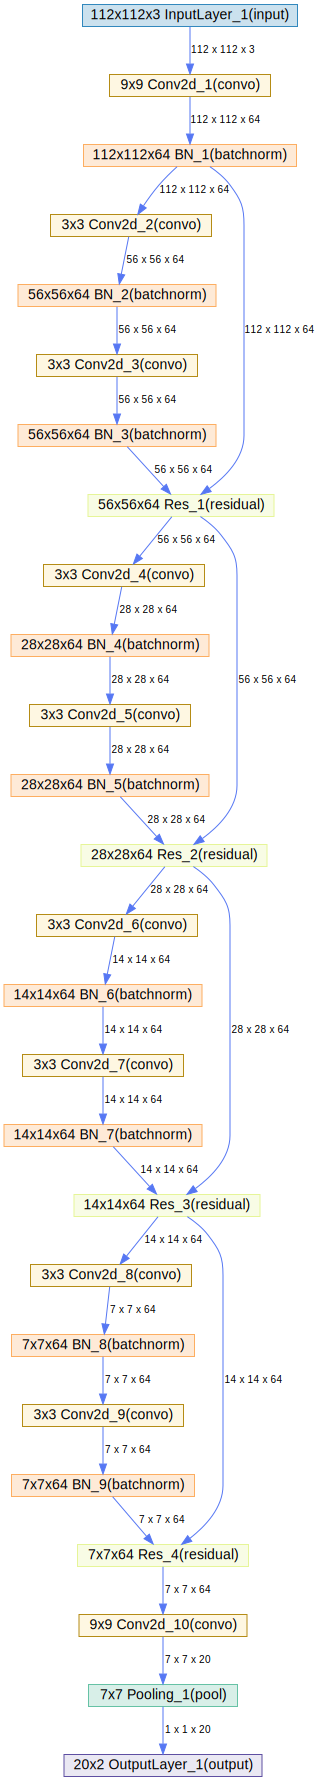

In [6]:
resnet_like_model.plot_network()

## Load data

In [7]:
img_path='/disk/linux/dlpy/Giraffe_Dolphin'
my_images = ImageTable.load_files(sess, path=img_path)
my_images.resize(112)

## Define Learning Rate

DLPy have some predefined learning rate policies.
1. FixedLR
2. StepLR
3. MultiStepLR
4. PolynomialLR
5. ReduceLROnPlateau
6. CyclicLR

Besides, you can also customize your own learning rate policy.

### Step Learning Rate

In [8]:
lr_scheduler = StepLR(learning_rate=0.0001, gamma=0.1, step_size=2)
solver = MomentumSolver(lr_scheduler=lr_scheduler, clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=16, log_level=3, max_epochs=5, reg_l2=0.0005)
gpu = Gpu(devices=[0])

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [9]:
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training from scratch.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       7.13 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64   0.0001           0.8923     0.4531     0.2989     0.3

,Descr,Value
0,Model Name,model_n3w4tj
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


### Cyclic Learning Rate Scheduler

In [10]:
lr_scheduler = CyclicLR(conn=sess, data=my_images, max_lr=0.01, batch_size=1, factor=2,
                        learning_rate=0.0001)
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=16, log_level=3, max_epochs=50, reg_l2=0.0005)

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [11]:
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       7.14 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64   0.0001            1.071     0.6094     0

NOTE:      6    64 0.009927          0.02431          0     0.2979     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  10       0.0099         0.03418   0.006696     0.31
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00505            0.062    0.01563     0.2978     0.05
NOTE:      1    64 0.005038          0.02959          0     0.2978     0.04
NOTE:      2    64 0.005026          0.01593          0     0.2978     0.04
NOTE:      3    64 0.005014          0.01677          0     0.2977     0.04
NOTE:      4    64 0.005002           0.0483    0.01563     0.2977     0.04
NOTE:      5    64 0.004989          0.03368    0.01563     0.2977     0.04
NOTE:      6    64 0.004977          0.02789    0.01563     0.2976     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  11        0.005         0.03345   0.008929     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm

NOTE:  23        0.005         0.01617   0.002232     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64   0.0001         0.006863          0     0.2955     0.05
NOTE:      1    64 0.000112         0.006835          0     0.2955     0.04
NOTE:      2    64 0.000124         0.006705          0     0.2955     0.04
NOTE:      3    64 0.000136         0.007391          0     0.2954     0.04
NOTE:      4    64 0.000148          0.03386    0.01563     0.2954     0.04
NOTE:      5    64 0.000161         0.007023          0     0.2954     0.04
NOTE:      6    64 0.000173         0.007988          0     0.2954     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  24       0.0002         0.01095   0.002232     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00505         0.008802          0     0.2954     0.05
NOTE:      1    64 0.005062          0

NOTE:      4    64 0.000148          0.00353          0     0.2931     0.04
NOTE:      5    64 0.000161         0.004546          0      0.293     0.04
NOTE:      6    64 0.000173         0.002985          0      0.293     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  36       0.0002        0.004171          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00505         0.009218          0      0.293     0.05
NOTE:      1    64 0.005062         0.004612          0      0.293     0.04
NOTE:      2    64 0.005074         0.003077          0      0.293     0.04
NOTE:      3    64 0.005086           0.1056     0.0625      0.293     0.04
NOTE:      4    64 0.005098         0.003125          0     0.2929     0.04
NOTE:      5    64 0.005111         0.004161          0     0.2929     0.04
NOTE:      6    64 0.005123           0.1274    0.04688     0.2929     0.04
NOTE:  Epoch Learning Rate       

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64   0.0001         0.002287          0     0.2909     0.05
NOTE:      1    64 0.000112         0.003794          0     0.2909     0.04
NOTE:      2    64 0.000124         0.006265          0     0.2909     0.04
NOTE:      3    64 0.000136         0.003082          0     0.2909     0.04
NOTE:      4    64 0.000148         0.003537          0     0.2908     0.04
NOTE:      5    64 0.000161         0.003569          0     0.2908     0.04
NOTE:      6    64 0.000173         0.004039          0     0.2908     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  48       0.0002        0.003796          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00505         0.002818          0     0.2908     0.05
NOTE:      1    64 0.005062          0.03863    0.03125     0.2908     0.04
NOTE:      2    64 0.

,Descr,Value
0,Model Name,model_n3w4tj
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


### Reduce Learning Rate on Plateau

In [12]:
lr_scheduler = ReduceLROnPlateau(conn=sess, cool_down_iters=2, gamma=0.1, learning_rate=0.01, patience=3)
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=16, log_level=3, max_epochs=50, reg_l2=0.0005)

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [13]:
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       6.93 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     0.01          0.00444          0     0

NOTE:      2    64    0.001           0.0279    0.01563      0.288     0.04
NOTE:      3    64    0.001         0.004087          0      0.288     0.04
NOTE:      4    64    0.001          0.00221          0      0.288     0.04
NOTE:      5    64    0.001         0.003832          0      0.288     0.04
NOTE:      6    64    0.001         0.002647          0      0.288     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  11        0.001        0.006749   0.002232     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64    0.001         0.002017          0      0.288     0.05
NOTE:      1    64    0.001         0.001843          0      0.288     0.04
NOTE:      2    64    0.001         0.002088          0      0.288     0.04
NOTE:      3    64    0.001         0.001927          0      0.288     0.04
NOTE:      4    64    0.001         0.002945          0      0.288     0.04
NOTE:      5    64    0.001      

NOTE:      3    64   0.0001         0.002211          0     0.2877     0.04
NOTE:      4    64   0.0001         0.003209          0     0.2877     0.04
NOTE:      5    64   0.0001         0.002548          0     0.2877     0.04
NOTE:      6    64   0.0001          0.00309          0     0.2877     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  22       0.0001         0.00306          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00001         0.003144          0     0.2877     0.05
NOTE:      1    64  0.00001         0.001503          0     0.2877     0.04
NOTE:      2    64  0.00001         0.002351          0     0.2877     0.04
NOTE:      3    64  0.00001         0.001807          0     0.2877     0.04
NOTE:      4    64  0.00001         0.003743          0     0.2877     0.04
NOTE:      5    64  0.00001         0.001947          0     0.2877     0.04
NOTE:      6    64  0.00001      

NOTE:      2    64     1E-6         0.001861          0     0.2877     0.04
NOTE:      3    64     1E-6         0.001961          0     0.2877     0.04
NOTE:      4    64     1E-6         0.004217          0     0.2877     0.04
NOTE:      5    64     1E-6         0.003583          0     0.2877     0.04
NOTE:      6    64     1E-6          0.00216          0     0.2877     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  34         1E-6        0.002696          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-6         0.002219          0     0.2877     0.05
NOTE:      1    64     1E-6         0.001796          0     0.2877     0.04
NOTE:      2    64     1E-6         0.001739          0     0.2877     0.04
NOTE:      3    64     1E-6          0.00271          0     0.2877     0.04
NOTE:      4    64     1E-6         0.002302          0     0.2877     0.04
NOTE:      5    64     1E-6      

NOTE:      4    64     1E-8         0.008139          0     0.2877     0.04
NOTE:      5    64     1E-8         0.003032          0     0.2877     0.04
NOTE:      6    64     1E-8         0.001974          0     0.2877     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  45         1E-8        0.003126          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-8         0.001689          0     0.2877     0.05
NOTE:      1    64     1E-8         0.002364          0     0.2877     0.04
NOTE:      2    64     1E-8         0.001991          0     0.2877     0.04
NOTE:      3    64     1E-8         0.002338          0     0.2877     0.04
NOTE:      4    64     1E-8         0.003557          0     0.2877     0.04
NOTE:      5    64     1E-8         0.003567          0     0.2877     0.04
NOTE:      6    64     1E-8         0.006266          0     0.2877     0.04
NOTE:  Epoch Learning Rate       

,Descr,Value
0,Model Name,model_n3w4tj
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


### Customize Learning Rate Policy

We also provide a flexible approach to define your learning rate policy using FCMP function.

In [14]:
cool_down_iters = 5
patience = 1
sess.addRoutines(
            routineCode = '''
                        function reduce_lr_on_plateau(rate, initRate, gamma, loss[*]);
                            len = dim(loss);
                            temp_rate = initRate;
                            cool_down_counter = {0};
                            best = loss[1];
                            do i=1 to len;
                    
                                if loss[i] < best then do;
                                    best = loss[i];
                                    bad_epoch = 0;
                                end;
                                else bad_epoch = bad_epoch + 1;
                    
                                if cool_down_counter > 0 then do;
                                    cool_down_counter = cool_down_counter - 1;
                                    bad_epoch = 0;
                                end;
                    
                                if bad_epoch > {1} then do;
                                    temp_rate = temp_rate * gamma;
                                    cool_down_counter = {0};
                                    bad_epoch = 0;
                                end;
                            end;
                            rate = temp_rate;
                            put rate=;
                            return(rate);
                        endsub;
                        '''.format(cool_down_iters, patience),
            package = 'pkg',
            funcTable = dict(name = 'reduce_lr_on_plateau', replace = 1))

+ Elapsed: 0.00318s, user: 0.00111s, sys: 0.00204s, mem: 3.31mb

Input your FCMP function name in fcmp_learning_rate 

In [15]:
lr_scheduler = FCMPLR(conn=sess, fcmp_learning_rate='reduce_lr_on_plateau',
                      learning_rate = 0.01, gamma = 0.1)
solver = MomentumSolver(lr_scheduler = lr_scheduler,
                        clip_grad_max = 100, clip_grad_min = -100)
optimizer = Optimizer(algorithm=solver, mini_batch_size=16, log_level=3, max_epochs=50, reg_l2=0.0005)

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


In [16]:
resnet_like_model.fit(data=my_images, 
                      n_threads=4, 
                      record_seed=13309, 
                      optimizer=optimizer,
                      gpu=gpu, 
                      log_level=2)

NOTE: Inputs=_image_ is used
NOTE: Training based on existing weights.
NOTE: Using dlgrd008.unx.sas.com: 1 out of 2 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 415358.
NOTE:  The approximate memory cost is 115.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost       6.90 (s).
NOTE:  The total number of threads on each worker is 4.
NOTE:  The total mini-batch size per thread on each worker is 16.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 64.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: Dolphin
NOTE:  Level      1: Giraffe
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     0.01         0.002573          0     0

NOTE:      3    64    0.001         0.001127          0     0.2842     0.04
NOTE:      4    64    0.001         0.001463          0     0.2842     0.04
NOTE:      5    64    0.001         0.001893          0     0.2842     0.04
NOTE:      6    64    0.001         0.001497          0     0.2842     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  11        0.001        0.001574          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64    0.001         0.002333          0     0.2842     0.05
NOTE:      1    64    0.001         0.001009          0     0.2842     0.04
NOTE:      2    64    0.001         0.001719          0     0.2842     0.04
NOTE:      3    64    0.001          0.00205          0     0.2842     0.04
NOTE:      4    64    0.001         0.001507          0     0.2841     0.04
NOTE:      5    64    0.001         0.001696          0     0.2841     0.04
NOTE:      6    64    0.001      

NOTE:      6    64   0.0001         0.001451          0     0.2839     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  22       0.0001        0.002278          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64  0.00001         0.001324          0     0.2839     0.05
NOTE:      1    64  0.00001         0.002333          0     0.2839     0.04
NOTE:      2    64  0.00001         0.002243          0     0.2839     0.04
NOTE:      3    64  0.00001         0.001762          0     0.2839     0.04
NOTE:      4    64  0.00001         0.001636          0     0.2839     0.04
NOTE:      5    64  0.00001        0.0009537          0     0.2839     0.04
NOTE:      6    64  0.00001         0.002356          0     0.2839     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  23         1E-5        0.001801          0     0.31
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm

NOTE:      3    64     1E-6         0.001079          0     0.2839     0.04
NOTE:      4    64     1E-6         0.002927          0     0.2839     0.04
NOTE:      5    64     1E-6         0.003049          0     0.2839     0.04
NOTE:      6    64     1E-6         0.001197          0     0.2839     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  34         1E-6        0.002103          0     0.30
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-6         0.002999          0     0.2839     0.05
NOTE:      1    64     1E-6         0.002152          0     0.2839     0.04
NOTE:      2    64     1E-6         0.001679          0     0.2839     0.04
NOTE:      3    64     1E-6         0.001789          0     0.2839     0.04
NOTE:      4    64     1E-6         0.001293          0     0.2839     0.04
NOTE:      5    64     1E-6         0.001856          0     0.2839     0.04
NOTE:      6    64     1E-6      

NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  45         1E-8        0.001731          0     0.31
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-8         0.001448          0     0.2839     0.05
NOTE:      1    64     1E-8         0.001468          0     0.2839     0.04
NOTE:      2    64     1E-8         0.002593          0     0.2839     0.04
NOTE:      3    64     1E-8         0.001386          0     0.2839     0.04
NOTE:      4    64     1E-8         0.001744          0     0.2839     0.04
NOTE:      5    64     1E-8         0.001393          0     0.2839     0.04
NOTE:      6    64     1E-8        0.0009173          0     0.2839     0.04
NOTE:  Epoch Learning Rate        Loss  Fit Error   Time(s)
NOTE:  46         1E-8        0.001564          0     0.31
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0    64     1E-8         0.000992          

,Descr,Value
0,Model Name,model_n3w4tj
1,Model Type,Convolutional Neural Network
2,Number of Layers,26
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,10
6,Number of Pooling Layers,1
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,9
9,Number of Residual Layers,4


In [17]:
sess.endsession()

+ Elapsed: 9e-05s, mem: 0.195mb